In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
pd.set_option("display.max_rows",101)

BASELINE_ALGORITHMS = ['cbf', 'mf', 'item-item']

MAX_RATINGS = [10, 20, 30]

algorithms_to_study = []

for max_rating in MAX_RATINGS:
    for algorithm_1 in BASELINE_ALGORITHMS:
        for algorithm_2 in BASELINE_ALGORITHMS:
            if algorithm_1 != algorithm_2:
                algorithms_to_study.append('switch_%s_%d_%s' % (algorithm_2, max_rating, algorithm_1))

ALGORITHMS = ['user-user'] + BASELINE_ALGORITHMS + algorithms_to_study
                
SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

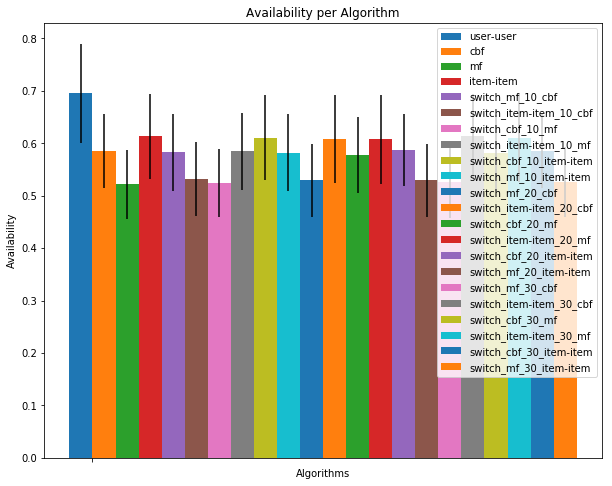

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
item-item,0.521144,0.558256,0.602912,0.665957,0.818278,0.825452,0.613373,0.453350,0.081052
switch_mf_10_cbf,0.498603,0.519200,0.566868,0.633840,0.738189,0.796798,0.582340,0.468187,0.073297
switch_item-item_10_cbf,0.468187,0.468187,0.498603,0.564393,0.704590,0.807144,0.531777,0.462140,0.070974
switch_cbf_10_mf,0.468187,0.468187,0.498603,0.564393,0.685752,0.802512,0.524639,0.468187,0.065249
switch_item-item_10_mf,0.509103,0.532006,0.566868,0.624356,0.796902,0.807144,0.584263,0.462140,0.073333
switch_cbf_10_item-item,0.510899,0.557728,0.593635,0.664089,0.818278,0.825452,0.610354,0.453350,0.081000
switch_mf_10_item-item,0.498603,0.519200,0.566868,0.633840,0.738189,0.796798,0.582290,0.468187,0.072974


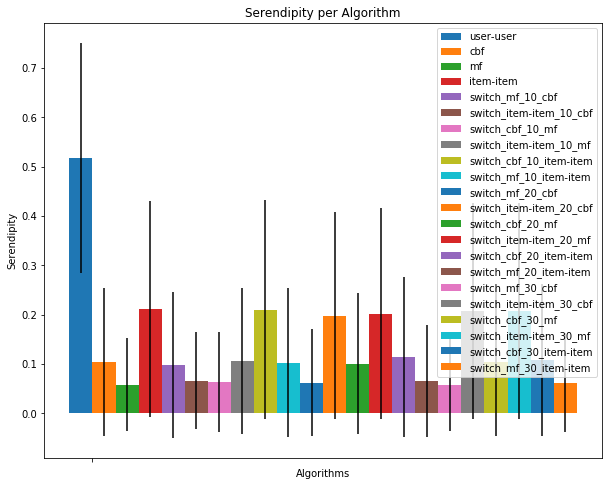

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.2,0.4,0.6,0.65,1.000,1.0,0.518,0.0,0.233401
cbf,0.0,0.0,0.0,0.20,0.602,0.8,0.104,0.0,0.150944
mf,0.0,0.0,0.0,0.20,0.202,0.4,0.058,0.0,0.095058
item-item,0.0,0.0,0.2,0.40,0.802,1.0,0.212,0.0,0.218760
switch_mf_10_cbf,0.0,0.0,0.0,0.20,0.602,0.8,0.098,0.0,0.148310
switch_item-item_10_cbf,0.0,0.0,0.0,0.20,0.202,0.4,0.066,0.0,0.098204
switch_cbf_10_mf,0.0,0.0,0.0,0.20,0.400,0.4,0.064,0.0,0.101509
switch_item-item_10_mf,0.0,0.0,0.0,0.20,0.602,0.8,0.106,0.0,0.148203
switch_cbf_10_item-item,0.0,0.0,0.2,0.40,0.802,1.0,0.210,0.0,0.221585
switch_mf_10_item-item,0.0,0.0,0.0,0.20,0.602,0.8,0.102,0.0,0.150983


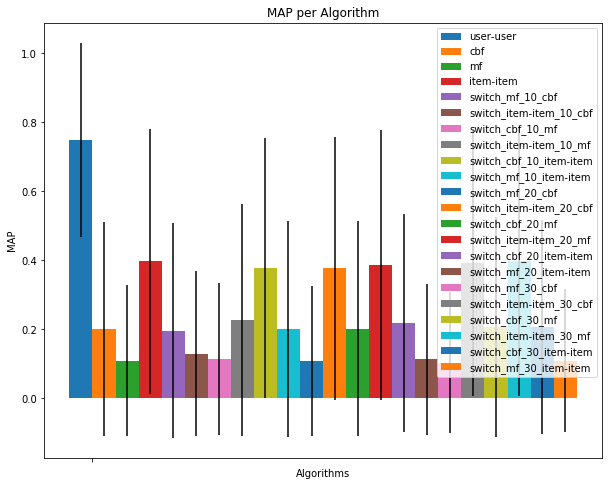

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.3325,0.588889,0.850000,1.000000,1.0,1.0,0.749278,0.0,0.281404
cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.202042,0.0,0.310513
mf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.109167,0.0,0.218548
item-item,0.0000,0.000000,0.291667,0.712500,1.0,1.0,0.397000,0.0,0.383009
switch_mf_10_cbf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.196375,0.0,0.311026
switch_item-item_10_cbf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.129500,0.0,0.238582
switch_cbf_10_mf,0.0000,0.000000,0.000000,0.200000,1.0,1.0,0.114833,0.0,0.220074
switch_item-item_10_mf,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.226708,0.0,0.336028
switch_cbf_10_item-item,0.0000,0.000000,0.250000,0.648958,1.0,1.0,0.377333,0.0,0.377295
switch_mf_10_item-item,0.0000,0.000000,0.000000,0.333333,1.0,1.0,0.201375,0.0,0.311847


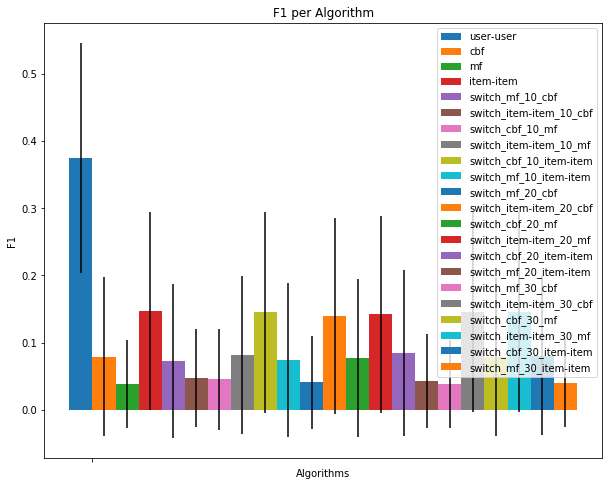

In [10]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


metric

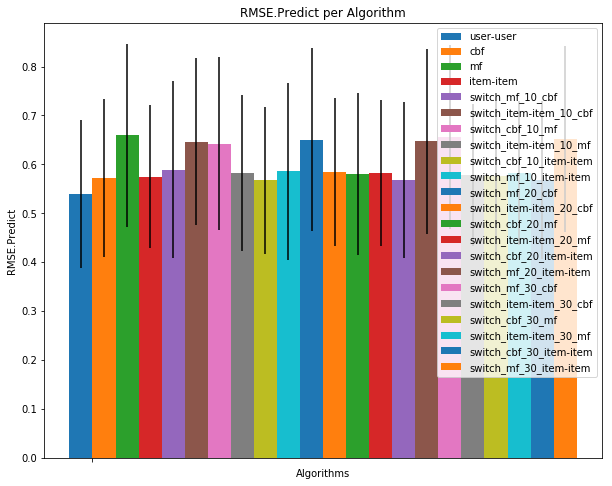

In [11]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [12]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
item-item,0.393176,0.488066,0.549393,0.634057,0.992785,1.028632,0.574672,0.335113,0.146474
switch_mf_10_cbf,0.373691,0.466921,0.568001,0.666601,1.069060,1.258139,0.589131,0.294183,0.180475
switch_item-item_10_cbf,0.440274,0.531404,0.634652,0.723461,1.056755,1.132080,0.646141,0.346146,0.170254
switch_cbf_10_mf,0.409246,0.513808,0.634652,0.728334,1.056755,1.132080,0.642285,0.266683,0.176153
switch_item-item_10_mf,0.373691,0.469969,0.568472,0.670457,0.989313,0.991441,0.582530,0.294183,0.158949
switch_cbf_10_item-item,0.393108,0.477859,0.547704,0.634057,1.017638,1.028632,0.567673,0.266683,0.150024
switch_mf_10_item-item,0.373691,0.465068,0.560469,0.666601,1.069060,1.258139,0.585602,0.294183,0.181071


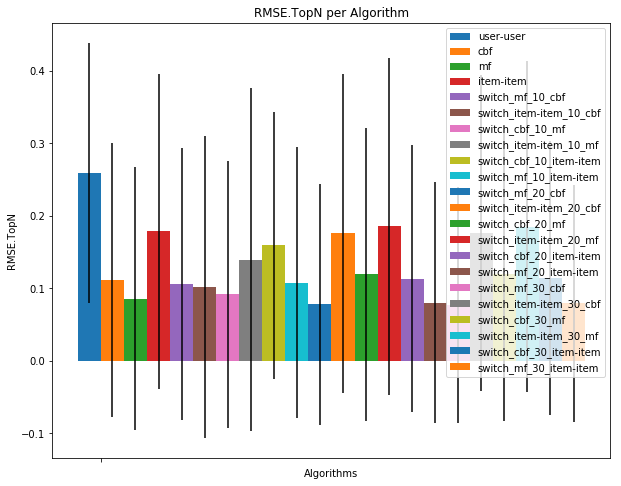

In [13]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [14]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
item-item,0.000000,0.000000,0.137183,0.293425,1.095363,1.143694,0.178520,0.0,0.216939
switch_mf_10_cbf,0.000000,0.000000,0.000000,0.143154,0.641167,0.811303,0.105830,0.0,0.187516
switch_item-item_10_cbf,0.000000,0.000000,0.000000,0.104163,0.885850,1.143694,0.102111,0.0,0.208727
switch_cbf_10_mf,0.000000,0.000000,0.000000,0.087007,0.670296,0.885882,0.091503,0.0,0.184166
switch_item-item_10_mf,0.000000,0.000000,0.000000,0.194175,0.888460,1.143694,0.139582,0.0,0.236903
switch_cbf_10_item-item,0.000000,0.000000,0.115103,0.270899,0.629511,1.094875,0.159230,0.0,0.184553
switch_mf_10_item-item,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.107838,0.0,0.187367


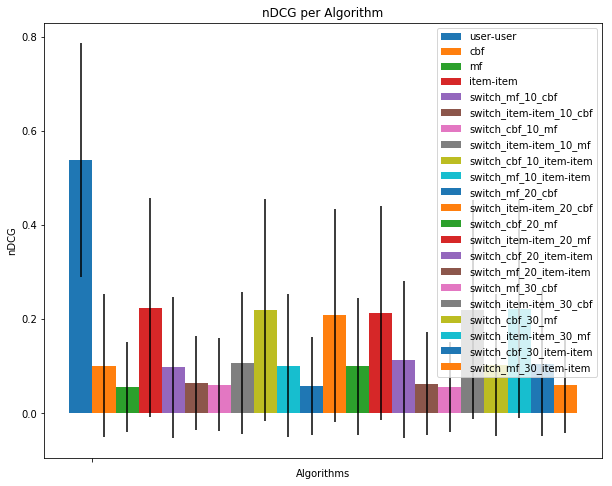

In [15]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [16]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.0,0.248525
cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.101620,0.0,0.150979
mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.057055,0.0,0.095502
item-item,0.000000,0.000000,0.197405,0.394809,0.880172,1.000000,0.224536,0.0,0.232487
switch_mf_10_cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.097672,0.0,0.149898
switch_item-item_10_cbf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.064305,0.0,0.099980
switch_cbf_10_mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.061003,0.0,0.098827
switch_item-item_10_mf,0.000000,0.000000,0.000000,0.242076,0.518268,0.757924,0.107366,0.0,0.150118
switch_cbf_10_item-item,0.000000,0.000000,0.152733,0.394809,0.880172,1.000000,0.220011,0.0,0.235094
switch_mf_10_item-item,0.000000,0.000000,0.000000,0.242076,0.518268,0.757924,0.101620,0.0,0.152451


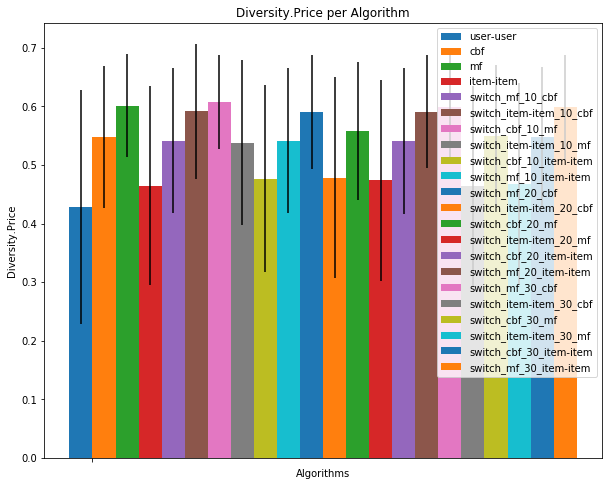

In [17]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [18]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.160,0.32,0.48,0.56,0.72,0.72,0.4288,0.00,0.200006
cbf,0.320,0.48,0.60,0.64,0.72,0.72,0.5472,0.24,0.121178
mf,0.400,0.64,0.64,0.64,0.64,0.64,0.6016,0.40,0.087985
item-item,0.240,0.32,0.48,0.64,0.72,0.72,0.4648,0.00,0.170344
switch_mf_10_cbf,0.320,0.46,0.60,0.64,0.72,0.72,0.5416,0.24,0.123861
switch_item-item_10_cbf,0.400,0.64,0.64,0.64,0.72,0.72,0.5920,0.00,0.115378
switch_cbf_10_mf,0.400,0.64,0.64,0.64,0.64,0.64,0.6072,0.32,0.080076
switch_item-item_10_mf,0.320,0.48,0.56,0.64,0.72,0.72,0.5384,0.00,0.140789
switch_cbf_10_item-item,0.312,0.32,0.48,0.64,0.72,0.72,0.4768,0.00,0.159968
switch_mf_10_item-item,0.320,0.48,0.60,0.64,0.72,0.72,0.5416,0.24,0.123343


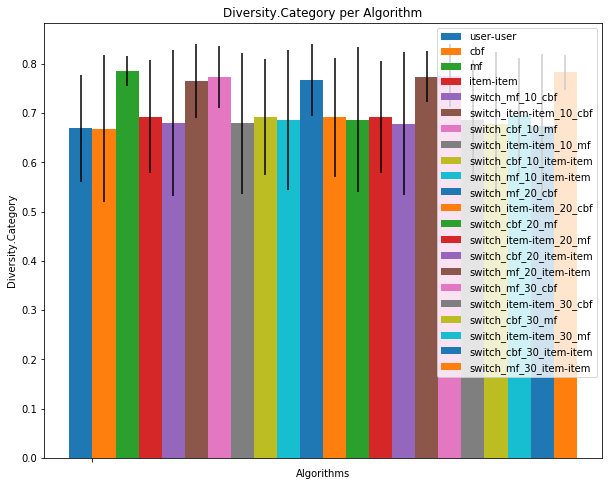

In [19]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [20]:
metric

,10,25,50,75,99,max,mean,min,std
user-user,0.56,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
cbf,0.56,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.72,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
item-item,0.56,0.64,0.72,0.80,0.8,0.8,0.6928,0.32,0.113825
switch_mf_10_cbf,0.56,0.64,0.72,0.80,0.8,0.8,0.6800,0.00,0.147729
switch_item-item_10_cbf,0.72,0.72,0.80,0.80,0.8,0.8,0.7656,0.32,0.075264
switch_cbf_10_mf,0.72,0.80,0.80,0.80,0.8,0.8,0.7736,0.32,0.063048
switch_item-item_10_mf,0.56,0.64,0.72,0.80,0.8,0.8,0.6792,0.00,0.142882
switch_cbf_10_item-item,0.56,0.64,0.72,0.80,0.8,0.8,0.6912,0.32,0.117858
switch_mf_10_item-item,0.56,0.64,0.72,0.80,0.8,0.8,0.6864,0.00,0.142292


In [21]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,item-item,mf,switch_cbf_10_item-item,switch_cbf_10_mf,switch_cbf_20_item-item,switch_cbf_20_mf,switch_cbf_30_item-item,switch_cbf_30_mf,switch_item-item_10_cbf,...,switch_item-item_20_mf,switch_item-item_30_cbf,switch_item-item_30_mf,switch_mf_10_cbf,switch_mf_10_item-item,switch_mf_20_cbf,switch_mf_20_item-item,switch_mf_30_cbf,switch_mf_30_item-item,user-user
0,0.205,0.53,0.045,0.495,0.11,0.225,0.195,0.205,0.2,0.265,...,0.525,0.53,0.53,0.195,0.195,0.115,0.12,0.07,0.09,0.755


In [22]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,item-item,mf,switch_cbf_10_item-item,switch_cbf_10_mf,switch_cbf_20_item-item,switch_cbf_20_mf,switch_cbf_30_item-item,switch_cbf_30_mf,switch_item-item_10_cbf,...,switch_item-item_20_mf,switch_item-item_30_cbf,switch_item-item_30_mf,switch_mf_10_cbf,switch_mf_10_item-item,switch_mf_20_cbf,switch_mf_20_item-item,switch_mf_30_cbf,switch_mf_30_item-item,user-user
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
